In [1]:
import numpy as np
import torch
import os
import pickle
import matplotlib.pyplot as plt
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (20, 20)
# plt.rcParams['image.interpolation'] = 'bilinear'

from argparse import ArgumentParser

from torch.optim import SGD, Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor, ToPILImage
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import lr_scheduler
from networks.SegUNet_new_version_coord_2channel_at_begin import SegUNet_new_version_coord_2channel_at_begin

import collections
import numbers
import random
import math
from PIL import Image, ImageOps, ImageEnhance
import logging
import time
import dataset
# import bcolz

In [2]:
CROSS_VALIDATION_FOLD = 0 # 0-4
SEED = CROSS_VALIDATION_FOLD * 100
NUM_CHANNELS = 5
NUM_CLASSES = 2 
model_name = 'SegUNet_new_version_coord_at_begin'
log_path = 'log/'
save_weights_path = '../_weights/'
if not os.path.exists(save_weights_path):
    os.makedirs(save_weights_path)
if not os.path.exists(log_path):
    os.makedirs(log_path)

In [3]:
log_filename = log_path + model_name + '-fold'+str(CROSS_VALIDATION_FOLD)+'.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, 
                   format='%(asctime)s:%(levelname)s:%(message)s')
def log(message):
    print(message)
    logging.info(message)

In [4]:
log('='*50 + 'start run' + '='*50)

==================================================start run==================================================


## dataset

In [5]:
image_path = '../../data/images/train/'
mask_path = '../../data/images/train_masks/'

In [6]:
with open('./train_shuffle_names.pk', 'rb') as f:
    filenames = pickle.load(f)

In [7]:
fold_num = len(filenames) // 5
folds = []
for i in range(5):
    if i == 4:
        folds.append(filenames[i * fold_num :])
    else:
        folds.append(filenames[i * fold_num : (i + 1) * fold_num])

train_filenames = []
for i in range(5):
    if i == CROSS_VALIDATION_FOLD:
        val_filenames = folds[i]
    else:
        train_filenames += folds[i]

In [8]:
# train_filenames = train_filenames[:4]
# val_filenames = val_filenames[:1]

In [9]:
train_set = dataset.Car_dataset(image_path, mask_path, train_filenames, Flip_to_same_side=True, ifcoord=True,
                        randomColor=False, randomCrop=True, crop_size=512, ifrotate=False, maxangle=5, stride=1)
val_set = dataset.Car_dataset(image_path, mask_path, val_filenames, Flip_to_same_side=True, ifcoord=True,
                        randomColor=False, randomCrop=True, crop_size=512, ifrotate=False, maxangle=5, stride=1)

train_loader = DataLoader(train_set, num_workers=4, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, num_workers=4, batch_size=4, shuffle=False) # for validation set

## dataset examples

In [10]:
inp, tar, cos = train_loader.__iter__().next()

In [11]:
i = 0
inp = Variable(inp)
tar = Variable(tar)
cos = Variable(cos)
# tar[:, 0]
t = tar[i].cpu().data.numpy()
inpu = inp[i].cpu().data.numpy()
cos = cos[i].cpu().data.numpy()

In [12]:
img_tensor = inp[i]
for ten, m, s in zip(img_tensor, [.229, .224, .225], [.485, .456, .406]):
    ten.mul_(m).add_(s)
img = ToPILImage()(img_tensor)

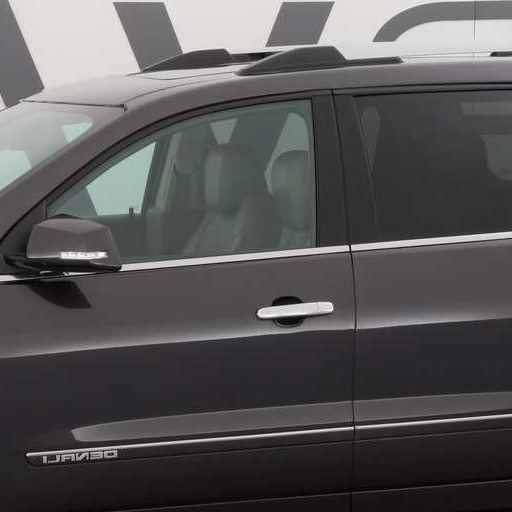

In [13]:
img

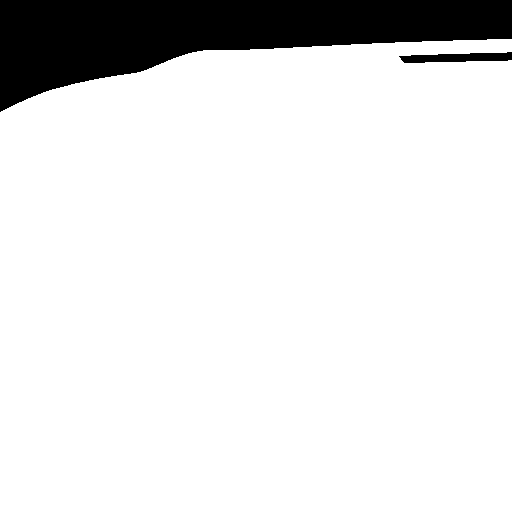

In [14]:
label = Image.fromarray(t[0].astype('uint8') * 255)
label

## train

In [15]:
def load_model(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    
def save_model(filename, model, optimizer):
    torch.save({'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict()}, 
                filename)

In [16]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.loss = nn.NLLLoss(weight, size_average)

    def forward(self, outputs, targets):
        return self.loss(F.log_softmax(outputs, dim=1), targets)

In [17]:
def train(epoch, steps_plot=0):
    model.train()

    criterion = CrossEntropyLoss2d() # loss function

    epoch_loss = []
    step_loss = []

    for step, (images, labels, coords) in enumerate(train_loader):
        
        images = images.cuda()
        labels = labels.cuda()
        coords = coords.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        coords = Variable(coords)
        outputs = model(inputs, coords)

        optimizer.zero_grad()
        loss = criterion(outputs, targets[:, 0])
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        step_loss.append(loss.item())
        
        if step % 10 == 0:
            average_step_loss = sum(step_loss) / len(step_loss)
            message = 'Epoch[{}]({}/{}): \tloss: {:.4}'.format(epoch, step, len(train_loader), average_step_loss)
            log(message)
            step_loss = []
    average = sum(epoch_loss) / len(epoch_loss)
    message = 'Train: Epoch[{}] \taverage loss: {:.4}'.format(epoch, average)
    log(message)

In [25]:
def test(steps_plot = 0):
    with torch.no_grad():
        model.eval()

        criterion = CrossEntropyLoss2d()

    #     for epoch in range(start_epoch, end_epochs+1):
        total_loss = []

        for step, (images, labels, coords) in enumerate(val_loader):

            images = images.cuda()
            labels = labels.cuda()
            coords = coords.cuda()

            inputs = Variable(images)
            targets = Variable(labels)
            coords = Variable(coords)
            outputs = model(inputs, coords)

            loss = criterion(outputs, targets[:, 0])

            total_loss.append(loss.item())

        average = sum(total_loss) / len(total_loss)
        message = 'Validation: \taverage loss: {:.4}'.format(average)
        log(message)
    return average

## train


In [19]:
torch.cuda.manual_seed_all(SEED)
model = SegUNet_new_version_coord_2channel_at_begin()
model = model.cuda()
optimizer = Adam(model.parameters(), lr = 1e-3)
# load_model('save_model_test.pth', model, optimizer)

In [ ]:
save_weights_path = '../_weights/'
scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
val_losses = []
start_time = time.time()
epoch_num = 250
for epoch in range(epoch_num):
    scheduler.step(epoch)
    message = 'learning rate: ' + str(scheduler.get_lr()[0])
    log(message)
    train(epoch)
    log('-'*100)
    
    if epoch == 0:
        t1 = time.time()
        message = 'one epoch time: ' + str(t1 - start_time) + 's'
        log(message)
        log('-'*100)
        
    val_loss = test()
    log('-'*100)
    
    val_losses.append(val_loss)
    if (val_loss == min(val_losses) and epoch >= 100) or (epoch + 1) % 50 == 0:
        save_file_name = save_weights_path+model_name+'-fold'+str(CROSS_VALIDATION_FOLD)+'-%.5f' % val_loss+'.pth'
        save_model(save_file_name, model, optimizer)
        
end_time = time.time()
total_time = end_time - start_time
average_time = total_time / epoch_num
message = 'total_time: ' + str(total_time) + 's' + '\t\taverage_time: ' + str(average_time) + 's'
log(message)

In [ ]:
save_file_name = save_weights_path+model_name+'-fold'+str(CROSS_VALIDATION_FOLD)+'end.pth'
save_model(save_file_name, model, optimizer)